In [1]:
import scipy.io
from scipy import signal
import numpy as np
import datetime
import matplotlib.pyplot as pl
def unpackStamp(x):
    y = np.int32(x[0])
    mo = np.int32(x[1])
    d = np.int32(x[2])
    h = np.int32(x[3])
    mi = np.int32(x[4])
    s = x[5]
    s_new = np.int32(np.floor(s))
    micros = np.int32((s - s_new) * 1e6)
    unpacked = datetime.datetime(y, mo, d, h, mi, s_new, micros)
    return unpacked

def events2samps(events, fs):
    firsteve_time = 0.4
    Nevents = events.shape[0]
    evesamps = np.zeros(Nevents)
    for k in range(Nevents):
        td =  unpackStamp(events[k, :]) - unpackStamp(events[0, :])
        evesamps[k] = np.int32(np.round(td.total_seconds()*fs + firsteve_time*fs + 1))
    
    return evesamps

# Part A

# A Q1

In [2]:
def one(file):
    #Q1
            fs=2048
            mat = scipy.io.loadmat(file)
            #for i in range(34):
            mat['data']-=((mat['data'][-2,:]+mat['data'][-1,:])/2)
               #1
            h_firwin = signal.firwin(int(fs/0.5),cutoff= [1, 12], pass_zero='bandpass', fs=fs) #to filter
            firwin = signal.filtfilt(h_firwin, 1, mat['data'][:32])
            data=firwin
            #2 The reason we filter before segmenting into epochs is to remove 
            #noise and extract the true signal. Doing it before segmenting also
            #helps in filtering the signals all together.
            event=mat['events']
            evesamps=events2samps(event,fs)
           
            epoch=np.zeros([data.shape[0],evesamps.shape[0],fs])
            for i in range(data.shape[0]):   
                 for k in range(evesamps.shape[0]):
                    epoch[i,k,:]= data[i,int(evesamps[k]):int(evesamps[k])+fs] #to extract the 1000ms epoch using fs
#                     #3extracting epochs
                    epoch[i,k,:]-= np.mean(epoch[i,k,0:205])
                    #4 to remove dc values
            a=np.all(np.abs(epoch)<=40,axis=2)
           
            a=np.all((a),axis=0)
        
            epoch=epoch[:32,a,:]
            #5 removing values greater than +- 40
    #Q2
            ct=0
            cnt=0 
           
            for j in range(epoch.shape[1]):     
                 if (mat['stimuli'][0,j]==mat['target'][0][0]):            
                               ct+=1
                 else:
                           cnt+=1     
            epochnontarget=np.zeros([epoch.shape[0],cnt,fs])
            epochtarget=np.zeros([epoch.shape[0],ct,fs])
            for i in range(epoch.shape[0]):
                for j in range(epoch.shape[1]):   
                     if (mat['stimuli'][0,j]==mat['target'][0][0]): 
                        for t in range(ct):
                              epochtarget[i,t,:]=  epoch[i,j,:]    
                     else:
                        for n in range(cnt):
                              epochnontarget[i,n,:]=  epoch[i,j,:]     
            #print(epochnontarget.shape,epochtarget.shape)
            return epochnontarget,epochtarget

In [3]:
import os
def two(directory):
    nont=np.zeros([34,2048])
    tar=np.zeros([34,2048])
    count=0
    tarls=[]
    nontarls=[]
    for root, subdirectories, files in os.walk(directory):
        #for subdirectory in subdirectories:
            #print(os.path.join(root, subdirectory))
        for file in files:  
            n,t=(one(os.path.join(root, file)))
            nontarls.append(n)
            tarls.append(t)
    nontar=np.hstack(nontarls)
    tar=np.hstack(tarls)
    nontarmean=np.mean(nontar,axis=1)
    tarmean=np.mean(tar,axis=1)
    dif=tarmean-nontarmean
    return nontar, tar,nontarmean,tarmean,dif

# A Q2
There is a p300 response on Fz,pz,cz and oz which are channel 30,31,13,and 16. These channel would be useful in discriminating target and non target  events.

(32, 19, 2048) (32, 91, 2048)
(32, 19, 2048) (32, 99, 2048)
(32, 2, 2048) (32, 5, 2048)
(32, 17, 2048) (32, 84, 2048)
(32, 19, 2048) (32, 93, 2048)
(32, 24, 2048) (32, 115, 2048)
(32, 22, 2048) (32, 109, 2048)
(32, 21, 2048) (32, 106, 2048)
(32, 17, 2048) (32, 88, 2048)
(32, 19, 2048) (32, 94, 2048)
(32, 20, 2048) (32, 99, 2048)
(32, 21, 2048) (32, 108, 2048)
(32, 21, 2048) (32, 107, 2048)
(32, 18, 2048) (32, 86, 2048)
(32, 18, 2048) (32, 94, 2048)
(32, 17, 2048) (32, 81, 2048)
(32, 19, 2048) (32, 98, 2048)
(32, 16, 2048) (32, 80, 2048)
(32, 16, 2048) (32, 82, 2048)
(32, 22, 2048) (32, 106, 2048)
(32, 19, 2048) (32, 91, 2048)
(32, 16, 2048) (32, 82, 2048)
(32, 17, 2048) (32, 86, 2048)
(32, 19, 2048) (32, 92, 2048)


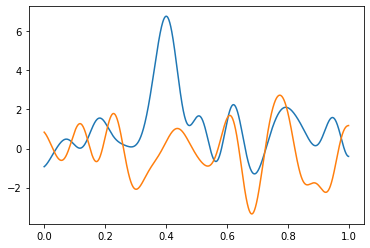

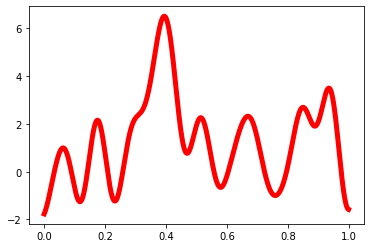

In [4]:
nontar, tar,nontarmean,tarmean,dif=two("./subject6")
time=np.arange(0, 1,1/2048).tolist()   
pl.plot(time,tarmean[30])
pl.plot(time,nontarmean[30])
pl.show()
pl.plot(time,dif[30],color='red',linewidth=5)
plt.legend(['difference between target and non tagrget average for subject 6'])
pl.show()

# A Q3
subject 6 and subject 4 are different whiCh means the BCI classfication for control and patient is different. Hence, one can potentially make a classfification based on peak time.
The peak for subjet 4 is between 0.8 and 1 seconds where as for subject 6 it is from 0.2 to 0.45.

(32, 17, 2048) (32, 89, 2048)
(32, 17, 2048) (32, 83, 2048)
(32, 17, 2048) (32, 86, 2048)
(32, 19, 2048) (32, 94, 2048)
(32, 16, 2048) (32, 78, 2048)
(32, 17, 2048) (32, 89, 2048)
(32, 20, 2048) (32, 97, 2048)
(32, 18, 2048) (32, 90, 2048)
(32, 18, 2048) (32, 94, 2048)
(32, 18, 2048) (32, 94, 2048)
(32, 16, 2048) (32, 78, 2048)
(32, 17, 2048) (32, 90, 2048)
(32, 14, 2048) (32, 72, 2048)
(32, 18, 2048) (32, 90, 2048)
(32, 18, 2048) (32, 88, 2048)
(32, 19, 2048) (32, 93, 2048)
(32, 19, 2048) (32, 98, 2048)
(32, 16, 2048) (32, 82, 2048)
(32, 17, 2048) (32, 87, 2048)
(32, 18, 2048) (32, 93, 2048)
(32, 18, 2048) (32, 91, 2048)
(32, 19, 2048) (32, 92, 2048)
(32, 18, 2048) (32, 88, 2048)
(32, 17, 2048) (32, 85, 2048)


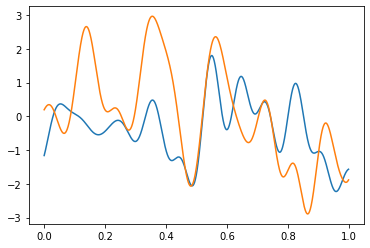

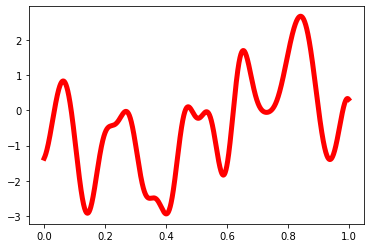

In [5]:
nontar, tar,nontarmean,tarmean,dif=two("./subject4")
time=np.arange(0, 1,1/2048).tolist()   
pl.plot(time,tarmean[30])
pl.plot(time,nontarmean[30])
pl.show()
pl.plot(time,dif[30],color='red',linewidth=5)
plt.legend(['difference between target and non tagrget average for subject 4'])
pl.show()


In [7]:
#B
def permtest(x1, x2):
    N1 = x1.shape[0]
    N2 = x2.shape[0]
    print(x2.shape,x1.shape)
    ls=[]
    ls.append(x1)
    ls.append(x2)
    bucket = np.vstack(ls)
    return bucket

In [12]:
def trial(bucket,Nperms,partition):
    N1 = int(tar.shape[1]/partition)
    N2 = int(nontar.shape[1]/partition)
    perms = np.zeros([Nperms,2048])
    time=np.arange(0, 1,1/2048).tolist()  
    for k in range(Nperms):
            x = np.random.permutation(bucket)
            x1perm = x[:N1]
            x2perm = x[N1:]
            perms[k] = np.mean(x1perm,axis=0) - np.mean(x2perm,axis=0)
            pl.plot(time,perms[k],color='grey')
    return perms

# B 1

(438, 2048) (2176, 2048)


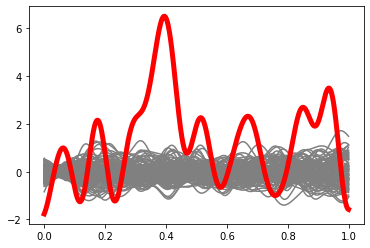

In [13]:
# nontar, tar,nontarmean,tarmean,dif=two("./subject6")
# Nreps=100
bucket=permtest(nontar[30], tar[30]) #non tar and tar are the epochs of size 32,438,2048 and 32,2176,2048
trial(bucket,100,1)
time=np.arange(0, 1,1/2048).tolist()  
pl.plot(time,dif[30],color='red',linewidth=5)
pl.show()

# Part B Q1
The difference between target and non target is more distinguishable
on time 0.2s to 0.45s
# Part B Q2
#The p value is 0.0

# B 2

In [ ]:
perms=trial(bucket,1000,1)
pl.plot(dif[30],color='red',linewidth=5)
pl.show()
p = np.float64((perms > np.amax(dif[30])).sum()) / 1000
print(p)

(438, 2048) (2176, 2048)


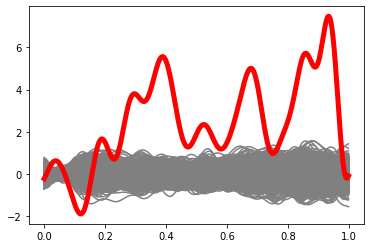

0.0
(438, 2048) (2176, 2048)


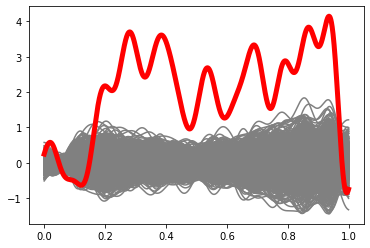

0.0
(438, 2048) (2176, 2048)


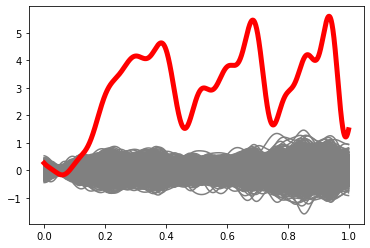

0.0


In [15]:

for i in ([31,13,16]):
    bucket=permtest(nontar[i], tar[i])
    perms=trial(bucket,1000,1)
    p = np.float64((perms > np.amax(dif[i])).sum()) / 1000
    pl.plot(time,dif[i],color='red',linewidth=5)
    pl.show()
    print(p)

# Part B Q3 
The p value is still 0 and the 1000 null examples of random averages are still not standing out from the peak for any of the channels. 
Channel 31 and 13 for time less than 0.2 have low differences between target and non target averages as compared to the null averages.
Channel 16 has three distinct sinusoidal peaks from 0.1 to 0.4sec, 0.4 to 0.77 sec and 0.77sec to 1 sec.

# Part C 

(109, 2048) (544, 2048)
p value for N/4 and M/4 is 0.0


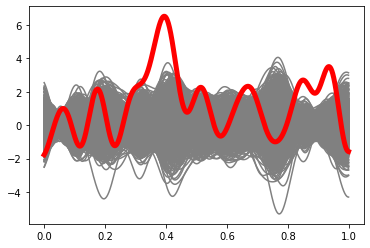

(18, 2048) (90, 2048)
0.733
p value for N/24 and M/24 is 0.733


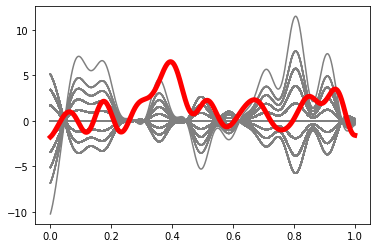

In [18]:
for i in ([30]):
    n=nontar.shape[1]
    t=tar.shape[1]
    bucket=permtest(nontar[i,:int(n/4)], tar[i,:int(t/4)])
    perms=trial(bucket,1000,4)
    p = np.float64((perms > np.amax(dif[i])).sum()) / 1000
    pl.plot(time,dif[i],color='red',linewidth=5)
print("p value for N/4 and M/4 is",p)
pl.show()
for i in ([30]):
    n=nontar.shape[1]
    t=tar.shape[1]
    bucket=permtest(nontar[i,:int(n/24)], tar[i,:int(t/24)])
    perms=trial(bucket,1000,24)
    p = np.float64((perms > np.amax(dif[i])).sum()) / 1000
    print(p)
    pl.plot(time,dif[i],color='red',linewidth=5)
print("p value for N/24 and M/24 is",p)

# C 1
As can be seen the N/24 and M/24 random averages are more distinct
than  N/4 and M/4. The p value for N/4,M/4 is 0 while for N/24,M/24 it is 0.733. This means as we reduce our files, the P values are likely to increase thus becoming harder to distinguish between null examples of random difference of averages from the actual difference of target and nontarget events. 

# C 2


(18, 2048) (90, 2048)
(18, 2048) (91, 2048)
(18, 2048) (91, 2048)
(19, 2048) (90, 2048)
(18, 2048) (91, 2048)
(18, 2048) (91, 2048)
(18, 2048) (90, 2048)
(19, 2048) (91, 2048)
(18, 2048) (91, 2048)
(18, 2048) (90, 2048)
(18, 2048) (91, 2048)
(19, 2048) (91, 2048)
(18, 2048) (90, 2048)
(18, 2048) (91, 2048)
(18, 2048) (91, 2048)
(19, 2048) (90, 2048)
(18, 2048) (91, 2048)
(18, 2048) (91, 2048)
(18, 2048) (90, 2048)
(19, 2048) (91, 2048)
(18, 2048) (91, 2048)
(18, 2048) (90, 2048)
(18, 2048) (91, 2048)
(19, 2048) (91, 2048)


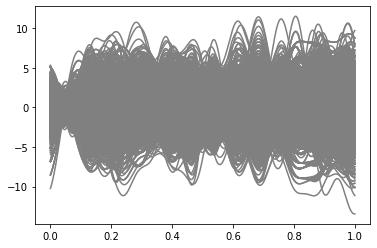

In [19]:
p=np.zeros(24)
for x in range(24):
    n=nontar.shape[1]
    t=tar.shape[1]
    bucket=permtest(nontar[30,int(n*x/24):int((x+1)*n/24)], tar[30,int(t*x/24):int((x+1)*t/24)])
    perms=trial(bucket,1000,24)
    p[x] = np.float64((perms > np.amax(dif[30])).sum()) / 1000


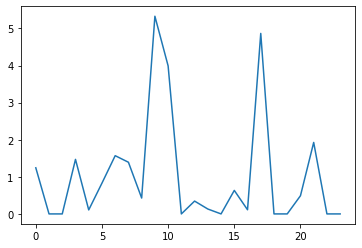

In [20]:
pl.plot(np.arange(0,24),p)

# C2
They are not consistent  because file 7-10 and 16-18 have much higher p values
around 4 to 5 while the rest fluctuate between 0-1.

# C3
Subject 6(control) is different from subject 4(patient). Using 1/24th of the data for subject(patient) 4 the actual difference is almost indistinguishable from the random averages.
subject 6 and subject 4 are different which means the BCI classfication for control and patient is different. Hence, one can potentially make a classfification based on peak time.
The peak for subjet 4 is between 0.8 and 1 seconds where as for subject 6 it is from 0.2 to 0.45 using the whole file.
Using 1/24 of the whole file, we can see subject 6 having a postive peak from 0.2 to 0.45 sec while subject 4 has a negative value(trough) with in that time frame.

(17, 2048) (88, 2048)
0.0
p value for N/24 and M/24 is 0.0


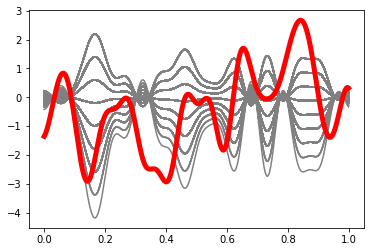

In [22]:
nontar, tar,nontarmean,tarmean,dif=two("./subject4")
for i in ([30]):
    n=nontar.shape[1]
    t=tar.shape[1]
    bucket=permtest(nontar[i,:int(n/24)], tar[i,:int(t/24)])
    perms=trial(bucket,1000,24)
    p = np.float64((perms > np.amax(dif[i])).sum()) / 1000
    pl.plot(time,dif[i],color='red',linewidth=5)
    print(p)
print("p value for N/24 and M/24 is",p)

(17, 2048) (88, 2048)
(18, 2048) (88, 2048)
(17, 2048) (89, 2048)
(18, 2048) (88, 2048)
(17, 2048) (88, 2048)
(18, 2048) (89, 2048)
(17, 2048) (88, 2048)
(18, 2048) (89, 2048)
(17, 2048) (88, 2048)
(18, 2048) (88, 2048)
(17, 2048) (89, 2048)
(18, 2048) (88, 2048)
(18, 2048) (88, 2048)
(17, 2048) (89, 2048)
(18, 2048) (88, 2048)
(17, 2048) (89, 2048)
(18, 2048) (88, 2048)
(17, 2048) (88, 2048)
(18, 2048) (89, 2048)
(17, 2048) (88, 2048)
(18, 2048) (88, 2048)
(17, 2048) (89, 2048)
(18, 2048) (88, 2048)
(18, 2048) (89, 2048)


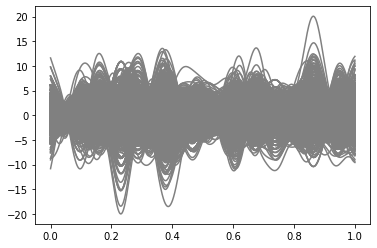

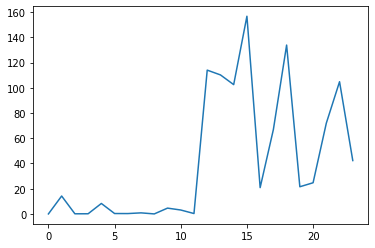

In [23]:
p=np.zeros(24)
for x in range(24):
    n=nontar.shape[1]
    t=tar.shape[1]
    bucket=permtest(nontar[30,int(n*x/24):int((x+1)*n/24)], tar[30,int(t*x/24):int((x+1)*t/24)])
    perms=trial(bucket,1000,24)
    p[x] = np.float64((perms > np.amax(dif[30])).sum()) / 1000
pl.show()
pl.plot(np.arange(0,24),p)

The p values are not consistent across files. The files after the 10th has a p value  that increases rapidly and of greater magnitude than subject 6.

# C 4

In [25]:
nontar, tar,nontarmean,tarmean,dif=two("./subject6")
nontarmean=np.mean(nontar,axis=1)
tarmean=np.mean(tar,axis=1)
print(tarmean.shape,nontarmean.shape)
dif=tarmean-nontarmean

(32, 19, 2048) (32, 91, 2048)
(32, 19, 2048) (32, 99, 2048)
(32, 2, 2048) (32, 5, 2048)
(32, 17, 2048) (32, 84, 2048)
(32, 19, 2048) (32, 93, 2048)
(32, 24, 2048) (32, 115, 2048)
(32, 22, 2048) (32, 109, 2048)
(32, 21, 2048) (32, 106, 2048)
(32, 17, 2048) (32, 88, 2048)
(32, 19, 2048) (32, 94, 2048)
(32, 20, 2048) (32, 99, 2048)
(32, 21, 2048) (32, 108, 2048)
(32, 21, 2048) (32, 107, 2048)
(32, 18, 2048) (32, 86, 2048)
(32, 18, 2048) (32, 94, 2048)
(32, 17, 2048) (32, 81, 2048)
(32, 19, 2048) (32, 98, 2048)
(32, 16, 2048) (32, 80, 2048)
(32, 16, 2048) (32, 82, 2048)
(32, 22, 2048) (32, 106, 2048)
(32, 19, 2048) (32, 91, 2048)
(32, 16, 2048) (32, 82, 2048)
(32, 17, 2048) (32, 86, 2048)
(32, 19, 2048) (32, 92, 2048)
(32, 2048) (32, 2048)


In [26]:
waveforms=np.hstack((nontar[[30,31,13,16]],tar[[30,31,13,16]]))
print(waveforms.shape)
print(waveforms[:,0].flatten().shape)
newnontar=waveforms[:nontar.shape[0]]
newtar=waveforms[nontar.shape[0]:]
waveforms=waveforms.reshape(waveforms.shape[1],waveforms.shape[0]*waveforms.shape[2])

(4, 2614, 2048)
(8192,)


In [27]:
cov = (1/waveforms.shape[0]) * np.matmul(waveforms.T, waveforms)
w,v = np.linalg.eig(cov)
sortInds = np.argsort(w) #smallest to largest
sortInds = np.flip(sortInds) #largest to smallest
w = w[sortInds]
v = v[:,sortInds]
q1 = v[:,0] 
q2 = v[:,1]

c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


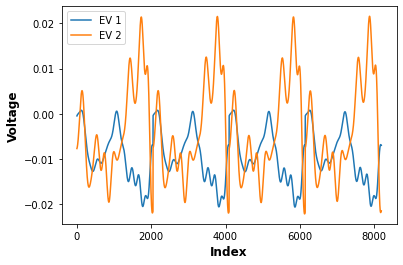

In [28]:
pl.figure()
pl.plot(q1, label='EV 1')
pl.plot(q2, label='EV 2')
pl.xlabel('Index',fontsize=12,fontweight='bold')
pl.ylabel('Voltage', fontsize=12,fontweight='bold')
pl.legend()
pl.show()

 # C Q5 There are smaller data points as k increases from 10 to 25 to 50. It becomes easier to see a separation between target and non target varaibles as well as k increases.

(8192, 1) (8192, 1)
(2614, 1) (2614, 1) (8192, 1) (8192, 1)


c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


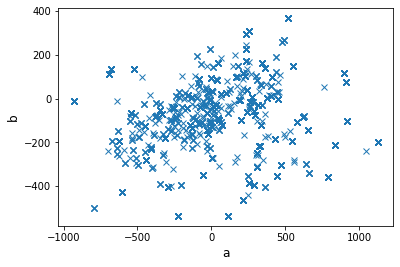

In [29]:
q1 = np.reshape(q1,(q1.size,1))
q2 = np.reshape(q2,(q2.size,1))
print(q1.shape,q1.shape)
a = np.matmul(waveforms,q1)
b = np.matmul(waveforms,q2)
print(a.shape,b.shape,q1.shape,q2.shape)
pl.figure()
pl.plot(a[:,0],b[:,0],marker ='x',linestyle='none')
pl.xlabel('a',fontsize=12)
pl.ylabel('b',fontsize=12)
pl.show()

(2176, 1) (2176, 1) (8192, 1) (8192, 1)
(4, 2176, 2048)


c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(438, 1)


c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


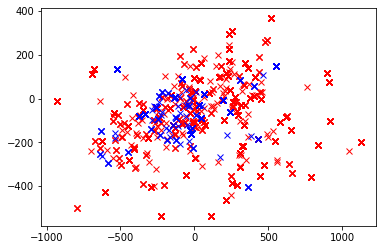

In [116]:
a = np.matmul(waveforms[:nontar[[30,31,13,16]].shape[1]],q1)
b = np.matmul(waveforms[:nontar[[30,31,13,16]].shape[1]],q2)
waveforms[:nontar.shape[0]]
newtar=waveforms[nontar.shape[0]:]
print(a.shape,b.shape,q1.shape,q2.shape)
print(nontar[[30,31,13,16]].shape)
pl.plot(a[:,0],b[:,0],marker ='x',linestyle='none',color='red')
a = np.matmul(waveforms[nontar[[30,31,13,16]].shape[1]:],q1)
b = np.matmul(waveforms[nontar[[30,31,13,16]].shape[1]:],q2)
print(a.shape)
pl.plot(a[:,0],b[:,0],marker ='x',linestyle='none',color='blue')

438 2048
wave (262, 8192)
a is 438
44
(44, 1) (262, 8192)


c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


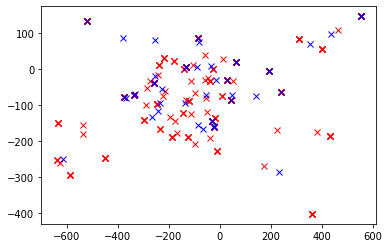

In [169]:
#K=10
from skimage.measure import block_reduce
print(tar[[30,31,13,16]].shape[1],nontar[[30,31,13,16]].shape[2])
arr_reducednon10 = block_reduce(nontar[[30,31,13,16]].T, block_size=(1,10,1), func=np.mean, cval=np.mean(nontar[[30,31,13,16]].T))
arr_reducedt10 = block_reduce(tar[[30,31,13,16]].T, block_size=(1,10,1), func=np.mean, cval=np.mean(tar[[30,31,13,16]].T))
wave10 = block_reduce(waveforms, block_size=(10,1), func=np.mean, cval=np.mean(waveforms))
print("wave",wave10.shape)
      
a10 = np.matmul(wave10[:arr_reducednon10.shape[1]],q1)
b10 = np.matmul(wave10[:arr_reducednon10.shape[1]],q2)
print("a is",a.shape[0])
pl.plot(a[:,0],b[:,0],marker ='x',linestyle='none',color='red')
a10 = np.matmul(wave10[arr_reducednon10.shape[1]:],q1)
b10 = np.matmul(wave10[arr_reducednon10.shape[1]:],q2)
print(a10.shape[0])
print(a10.shape,wave10.shape)
pl.plot(a10[:,0],b10[:,0],marker ='x',linestyle='none',color='blue')

For K=10, there is a pattern between -600 and 500 for a and -300 to 200 for b that show mostly the target variable. Regions elsewhere are mostly non target.

438 2048
waveforms (2614, 8192)
wave (105, 8192)
a is 88
17
(17, 1) (105, 8192)


c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


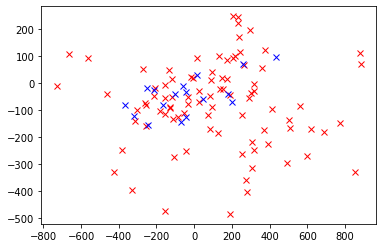

In [40]:
#K=25
print(tar[[30,31,13,16]].shape[1],nontar[[30,31,13,16]].shape[2])
arr_reducednon = block_reduce(nontar[[30,31,13,16]].T, block_size=(1,25,1), func=np.mean, cval=np.mean(nontar[[30,31,13,16]].T))

arr_reducedt = block_reduce(tar[[30,31,13,16]].T, block_size=(1,25,1), func=np.mean, cval=np.mean(tar[[30,31,13,16]].T))
print("waveforms",waveforms.shape)
wave = block_reduce(waveforms, block_size=(25,1), func=np.mean, cval=np.mean(waveforms))
a = np.matmul(wave[:arr_reducednon.shape[1]],q1)
b = np.matmul(wave[:arr_reducednon.shape[1]],q2)
print("a is",a.shape[0])
pl.plot(a[:,0],b[:,0],marker ='x',linestyle='none',color='red')
a = np.matmul(wave[arr_reducednon.shape[1]:],q1)
b = np.matmul(wave[arr_reducednon.shape[1]:],q2)
print(a.shape[0])
print(a.shape,wave.shape)
pl.plot(a[:,0],b[:,0],marker ='x',linestyle='none',color='blue')

For K=25, there is a pattern between -400 and 400 for a and -200 to 100 for b that show mostly the target variable. 
Regions elsewhere are mostly non target.

438 2048
a is 44
9
(9, 1) (53, 8192)


c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\tewbe\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


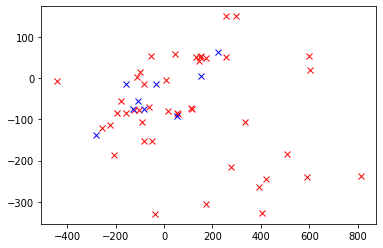

In [34]:
#K=50
print(tar[[30,31,13,16]].shape[1],nontar[[30,31,13,16]].shape[2])
arr_reducednon = block_reduce(nontar[[30,31,13,16]].T, block_size=(1,50,1), func=np.mean, cval=np.mean(nontar[[30,31,13,16]].T))

arr_reducedt = block_reduce(tar[[30,31,13,16]].T, block_size=(1,50,1), func=np.mean, cval=np.mean(tar[[30,31,13,16]].T))

wave = block_reduce(waveforms, block_size=(50,1), func=np.mean, cval=np.mean(waveforms))
a = np.matmul(wave[:arr_reducednon.shape[1]],q1)
b = np.matmul(wave[:arr_reducednon.shape[1]],q2)
print("a is",a.shape[0])
pl.plot(a[:,0],b[:,0],marker ='x',linestyle='none',color='red')
a = np.matmul(wave[arr_reducednon.shape[1]:],q1)
b = np.matmul(wave[arr_reducednon.shape[1]:],q2)
print(a.shape[0])
print(a.shape,wave.shape)
pl.plot(a[:,0],b[:,0],marker ='x',linestyle='none',color='blue')

For K=50, there is a pattern between -150 and 75 for b and -300 to 200 for a that show mostly the target variable. Regions elsewhere are mostly non target.

# C 6
I would prefer fewer misses because we are trying to study brain response when the patient is trying to select a target object and we also have fewer target variables. Hence, I prefer to see each target response that can happen.

0.0
0.4883720930232558
0.5116279069767442
0.023255813953488372
0.4883720930232558
0.4883720930232558
0.0
0.0


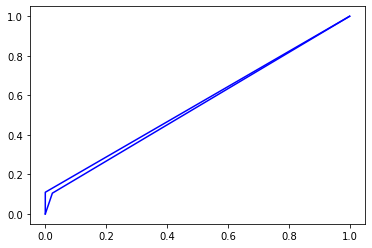

In [182]:
from sklearn import metrics
ytrue=np.zeros(wave10.shape[0])
lsfpr=[]
lstpr=[]

#1
ytrue=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if i>arr_reducednon10.shape[1]:
        ytrue[i] = 0
    else:
        ytrue[i] = 1

ypred=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if ( -600 < a[i] and a[i] < -400):
        ypred[i]=1    
    else:
        ypred[i]=0
fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
pl.plot(fpr, tpr, 'b')
lsfpr.append(fpr[1])
lstpr.append(tpr[1])
print(fpr[1])
pl.plot( tpr[1], fpr[1],'b')
#2
ytrue=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if i>arr_reducednon10.shape[1]:
        ytrue[i] = 0
    else:
        ytrue[i] = 1
ypred=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if ( -500 < a[i] and a[i] < -300):
        ypred[i]=1    
    else:
        ypred[i]=0
fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
lsfpr.append(fpr[1])
lstpr.append(tpr[1])
print(fpr[1])
pl.plot( tpr[1], fpr[1],'b')
#3

ytrue=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if i>arr_reducednon10.shape[1]:
        ytrue[i] = 0
    else:
        ytrue[i] = 1
ypred=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if ( -400 < a[i] and a[i] < -200):
        ypred[i]=1    
    else:
        ypred[i]=0
fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
lsfpr.append(fpr[1])
lstpr.append(tpr[1])
print(fpr[1])
pl.plot( tpr[1], fpr[1],'b')
#4
ytrue=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if i>arr_reducednon10.shape[1]:
        ytrue[i] = 0
    else:
        ytrue[i] = 1
ypred=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if ( -300 < a[i] and a[i] < -100):
        ypred[i]=1    
    else:
        ypred[i]=0
fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
pl.plot(fpr, tpr, 'b')
lsfpr.append(fpr[1])
lstpr.append(tpr[1])
print(fpr[1])
pl.plot( tpr[1], fpr[1],'b')
#5
ytrue=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if i>arr_reducednon10.shape[1]:
        ytrue[i] = 0
    else:
        ytrue[i] = 1
ypred=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if ( -200 < a[i] and a[i] < 0):
        ypred[i]=1    
    else:
        ypred[i]=0
fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
pl.plot( tpr[1], fpr[1],'b')
lsfpr.append(fpr[1])
lstpr.append(tpr[1])
print(fpr[1])
#6

ytrue=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if i>arr_reducednon10.shape[1]:
        ytrue[i] = 0
    else:
        ytrue[i] = 1
ypred=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if ( -100 < a[i] and a[i] < 100):
        ypred[i]=1    
    else:
        ypred[i]=0
fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
pl.plot( tpr[1], fpr[1],'b')
lsfpr.append(fpr[1])
lstpr.append(tpr[1])
print(fpr[1])
#7
for i in range(wave10.shape[0]):
    if i>arr_reducednon10.shape[1]:
        ytrue[i] = 0
    else:
        ytrue[i] = 1
ypred=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if (0 < a[i] and a[i] < 200):
        ypred[i]=1    
    else:
        ypred[i]=0
fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
pl.plot( tpr[1], fpr[1],'b')
lsfpr.append(fpr[1])
lstpr.append(tpr[1])
print(fpr[1])
#8
lsfpr.append(fpr[1])
lstpr.append(tpr[1])
ytrue=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if i>arr_reducednon10.shape[1]:
        ytrue[i] = 0
    else:
        ytrue[i] = 1
ypred=np.zeros(wave10.shape[0])
for i in range(wave10.shape[0]):
    if ( 100 < a[i] and a[i] < 300 ):
        ypred[i]=1    
    else:
        ypred[i]=0
fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
print(fpr[1])
pl.plot( tpr[1], fpr[1],'b')
lsfpr.append(fpr[1])
lstpr.append(tpr[1])

[0, 6, 7, 8, 3, 1, 4, 5, 2]
f [0.         0.         0.         0.         0.02325581 0.48837209
 0.48837209 0.48837209 0.51162791]


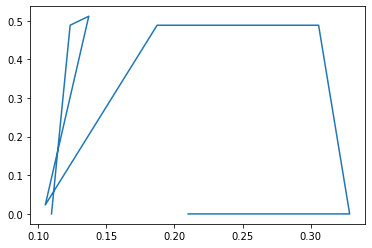

In [184]:
f=np.asarray(lsfpr).argsort()
t=np.asarray(lstpr).argsort()
ff=np.asarray(lsfpr)
tt=np.asarray(lstpr)
print(f.tolist())
print("f",ff[f])
pl.plot(lstpr,lsfpr)


# C6
Another way to classiffy is to use clustering perhaps KNN instead of ROC